### Importing non-mrcnn libraries and setting up directories

In [50]:
import cv2
import os
import sys
import random
import math
import numpy as np
import skimage.io as skio
import matplotlib
import matplotlib.pyplot as plt
import copy
from skimage import measure
%matplotlib inline

# Root directory of the project
ROOT_DIR = os.path.abspath("/home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "models")

# # Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")
# # Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)
EIGHTCHANNEL_DIR = os.path.join(ROOT_DIR, 'eightchannels')
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')
TEST_DIR = os.path.join(ROOT_DIR, 'test')
WV2_DIR = os.path.join(ROOT_DIR, 'gridded_wv2')
LABELS_DIR = os.path.join(ROOT_DIR, 'gridded_wv2_labels')
CONNECTED_COMP_DIR = os.path.join(ROOT_DIR, 'connected_comp_labels')
OPENED_LABELS_DIR = os.path.join(ROOT_DIR, 'opened_labels')
try:
    os.mkdir(OPENED_LABELS_DIR)
    os.mkdir(CONNECTED_COMP_DIR)
    os.mkdir(EIGHTCHANNEL_DIR)
    os.mkdir(MODEL_DIR)
    os.mkdir(TRAIN_DIR)
    os.mkdir(TEST_DIR)
    os.mkdir(WV2_DIR)
    os.mkdir(LABELS_DIR)
except:
    FileExistsError

os.chdir(ROOT_DIR)

### Stacking on/off season pairs into single 8 channel tif files and moving them to 8channel directory.

In [51]:
def load_merge_wv2(image_id, source_dir):
    """Load the specified wv2 os/gs image pairs and return a [H,W,8] 
    Numpy array. Channels are ordered [B, G, R, NIR, B, G, R, NIR], OS 
    first.
    """
    # Load image
    os_path = source_dir+'/'+image_id+'_MS_OS.tif'
    gs_path = source_dir+'/'+image_id+'_MS_GS.tif'
    os_image = skio.imread(os_path)
    gs_image = skio.imread(gs_path)
    # If has more than 4 bands, select correct bands 
    # will need to provide image config in future
    # to programmaticaly use correct band mappings
    if os_image.shape[-1] != 4:
        os_image = np.dstack((os_image[:,:,1:3],os_image[:,:,4],os_image[:,:,6]))
    if gs_image.shape[-1] != 4:
        gs_image = np.dstack((gs_image[:,:,1:3],gs_image[:,:,4],gs_image[:,:,6]))
    stacked_image = np.dstack((os_image, gs_image))
    stacked_image_path = EIGHTCHANNEL_DIR +'/'+ image_id + '_OSGS_ms.tif'
    assert stacked_image.ndim == 3
    skio.imsave(stacked_image_path,stacked_image, plugin='tifffile')

# all files, including ones we don't care about
file_ids_all = next(os.walk(WV2_DIR))[2]
# all multispectral on and off season tifs
image_ids_all = [image_id for image_id in file_ids_all if 'MS' in image_id]
#check for duplicates
assert len(image_ids_all) == len(set(image_ids_all))

image_ids_gs = [image_id for image_id in image_ids_all if 'GS' in image_id]
image_ids_os = [image_id for image_id in image_ids_all if 'OS' in image_id]

#check for equality
assert len(image_ids_os) == len(image_ids_gs)

image_ids_short = [image_id[0:9] for image_id in image_ids_gs]

for imid in image_ids_short:
    load_merge_wv2(imid, WV2_DIR)
    
# trying to save 8 channel numpy array with GS, OS info. this is what matterport expects
# BUT in mold_inputs() in https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/model.py
# indicates that the input png/array must only have three channels...
# We could change mold_inputs to not have this requirement and also change
#         input_image = KL.Input(
#            shape=[None, None, 3], name="input_image")
# on line 1841 of mrcnn/model.py but not sure if this is all the changes
# that would be required
# this issue indicates fix is simpler: https://github.com/matterport/Mask_RCNN/issues/314


In [52]:
image_list = next(os.walk(EIGHTCHANNEL_DIR))[2]
def move_img_to_folder(filename):
    '''Moves a file with identifier pattern ZA0165086_MS_GS.tif to a 
    folder path ZA0165086/image/ZA0165086_MS_GS.tif
    Also creates a masks folder at ZA0165086/masks'''
    
    folder_name = os.path.join(TRAIN_DIR,filename[:9])
    os.mkdir(folder_name)
    new_path = os.path.join(folder_name, 'image')
    mask_path = os.path.join(folder_name, 'masks')
    os.mkdir(new_path)
    file_path = os.path.join(EIGHTCHANNEL_DIR,filename)
    os.rename(file_path, os.path.join(new_path, filename))
    os.mkdir(mask_path)
    
for img in image_list:
    move_img_to_folder(img)
print('done moving images')

done moving images


### Erosion/Dilation to get rid of really small partial fields created due to edge effects

In [53]:
label_list = next(os.walk(LABELS_DIR))[2]

In [54]:
from skimage import morphology as skim
for name in label_list:
    arr = skio.imread(os.path.join(LABELS_DIR,name))
    arr[arr == -1.7e+308]=0
    label_name = name[0:15]+'.tif'
    opened_path = os.path.join(OPENED_LABELS_DIR,name)
    kernel = np.ones((5,5))
    arr = skim.binary_opening(arr, kernel)
    arr=1*arr
    assert arr.ndim == 2
    skio.imsave(opened_path, 1*arr)

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0797033_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0958603_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0488124_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0159899_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_i

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0558651_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0806266_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0956736_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0121777_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_i

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0162471_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0560061_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0116362_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0159036_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_i

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0115609_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0966040_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0960466_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0793320_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_i

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0951137_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0489754_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0490762_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0806036_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_i

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0491079_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0953008_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0120984_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0115604_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_i

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0967897_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0161609_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0488442_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0120212_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_i

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0808107_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0795177_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0120210_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0562911_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_i

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0492392_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0794955_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0119435_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0495041_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_i

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0484512_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0954876_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0158189_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0485816_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_i

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0565814_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0493397_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0484515_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0954871_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_i

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0122568_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0119432_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0558649_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0120205_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_i

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0158183_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0117894_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0964183_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0489760_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_i

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0795182_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0568738_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0804206_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0798887_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_i

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0793318_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0964180_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0117897_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0120209_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_i

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0802364_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0557240_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0804201_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/opened_labels/ZA0953013_label.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_i

### Connected Components on wv2 labels, move them to connected comps folder

Does keeping no data from partial grid coverage lead to too much edge effects?
Should the arrays be opened before saved as seperate masks? The degree to which they are is a tuning param. 

In [55]:
label_list = next(os.walk(OPENED_LABELS_DIR))[2]

In [56]:
for name in label_list:
    arr = skio.imread(os.path.join(OPENED_LABELS_DIR,name))
    blob_labels = measure.label(arr, background=0)
    print(blob_labels.shape, 'blob')
    blob_vals = np.unique(blob_labels)
    for blob_val in blob_vals[blob_vals!=0]:
        labels_copy = blob_labels.copy()
        labels_copy[blob_labels!=blob_val] = 0
        labels_copy[blob_labels==blob_val] = 1
        label_name = name[0:15]+str(blob_val)+'.tif'
        label_path = os.path.join(CONNECTED_COMP_DIR,label_name)
        print(labels_copy.shape, 'copy')
        assert labels_copy.ndim == 2
        skio.imsave(label_path, labels_copy)

(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(264, 264) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(263, 263) blob
(266, 266) blob
(266, 266) copy
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(262, 262) blob
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(264, 264) blob
(264, 264) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0795178_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0795178_label2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0795178_label3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0808108_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(263, 263) blob
(263, 263) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) copy
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(262, 262) copy
(262, 262) copy
(262, 262) copy
(262, 262) blob
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(264, 264) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0163344_label18.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0163344_label19.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0163344_label20.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0163344_label21.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/l

(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) copy
(266, 266) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(264, 264) blob
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(262, 262) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(262, 262) blob
(264, 264) blob
(266, 266) blob
(262, 262) blob
(262, 262) copy
(262, 262) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(262, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0164209_label16.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0164209_label17.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0164209_label18.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0164209_label19.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/l

(266, 266) copy
(266, 266) copy
(262, 262) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(263, 263) blob
(263, 263) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(263, 263) blob
(263, 263) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(264, 264) blob
(262, 262) blob
(266, 266) blob
(266, 266) blob
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(264, 264) blob
(262, 262) blob
(262, 262) copy
(262, 262) blob
(264, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0116364_label2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0116364_label3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0116364_label4.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0116364_label5.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

(263, 263) copy
(263, 263) copy
(263, 263) blob
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(262, 262) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(266, 266) blob
(266, 266) blob
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(266, 266) blob
(264, 264) blob
(264, 264) copy
(266, 266) blob
(262, 262) blob
(262, 262) copy
(262, 262) copy
(263, 263) blob
(263, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0967899_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0967899_label2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0967899_label3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0798893_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(263, 263) blob
(263, 263) copy
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(262, 262) copy
(263, 263) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(264, 264) blob
(264, 264) copy
(263, 263) blob
(263, 263) blob
(266, 266) blob
(266, 266) blob
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(266, 266) blob
(264, 264) blob
(264, 264) copy
(264, 264) copy
(266, 266) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(262, 262) blob
(263, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0561486_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0561486_label2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0561486_label3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0962321_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

(266, 266) copy
(266, 266) copy
(266, 266) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(266, 266) blob
(264, 264) blob
(264, 264) copy
(264, 264) copy
(263, 263) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(262, 262) blob
(263, 263) blob
(266, 266) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(263, 263) blob
(264, 264) blob
(266, 266) blob
(264, 264) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(263, 263) blob
(264, 264) blob
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(262, 262) copy
(262, 262) copy
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(263, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0493719_label5.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0560063_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0560063_label2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0491074_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

(266, 266) blob
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(263, 263) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(263, 263) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(262, 262) copy
(262, 262) copy
(264, 264) blob
(264, 264) copy
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0560062_label5.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0560062_label6.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0560062_label7.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0560062_label8.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

(262, 262) copy
(262, 262) copy
(264, 264) blob
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(266, 266) blob
(266, 266) copy
(266, 266) copy
(263, 263) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(262, 262) blob
(266, 266) blob
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(264, 264) blob
(266, 266) blob
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(264, 264) blob
(263, 263) blob
(263, 263) blob
(264, 264) blob
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(263, 263) blob
(263, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0967892_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0967892_label2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0967892_label3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0806037_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) blob
(264, 264) blob
(263, 263) blob
(262, 262) blob
(262, 262) copy
(262, 262) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(264, 264) blob
(266, 266) blob
(263, 263) blob
(263, 263) copy
(266, 266) blob
(266, 266) copy
(264, 264) blob
(266, 266) blob
(266, 266) blob
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0796809_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0796809_label2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0796809_label3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0795173_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

(266, 266) blob
(266, 266) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(262, 262) blob
(264, 264) blob
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(263, 263) blob
(266, 266) blob
(264, 264) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(264, 264) blob
(266, 266) blob
(264, 264) blob
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(263, 263) blob
(263, 263) blob
(263, 263) copy
(263, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0567269_label4.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0567269_label5.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0567269_label6.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0567269_label7.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(263, 263) blob
(264, 264) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(263, 263) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(264, 264) blob
(263, 263) blob
(266, 266) blob
(264, 264) blob
(263, 263) blob
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(266, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0488440_label3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0488440_label4.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0488440_label5.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0488440_label6.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

(263, 263) copy
(263, 263) copy
(263, 263) blob
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(264, 264) blob
(264, 264) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(263, 263) blob
(264, 264) blob
(263, 263) blob
(266, 266) blob
(264, 264) blob
(264, 264) blob
(264, 264) copy
(264, 264) blob
(264, 264) copy
(264, 264) copy
(263, 263) blob
(263, 263) copy
(264, 264) blob
(262, 262) blob
(263, 263) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) blob
(264, 264) blob
(264, 264) copy
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0493402_label5.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0493402_label6.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0493402_label7.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0493402_label8.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

(263, 263) blob
(263, 263) copy
(262, 262) blob
(262, 262) copy
(263, 263) blob
(263, 263) copy
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(263, 263) blob
(266, 266) blob
(266, 266) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(262, 262) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(266, 266) blob
(263, 263) blob
(263, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0800512_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0800512_label2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0800512_label3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0800512_label4.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) blob
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(266, 266) blob
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(263, 263) blob
(263, 263) copy
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(266, 266) blob
(263, 263) blob
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(263, 263) blob
(263, 263) copy
(263, 263) blob
(266, 266) blob
(266, 266) blob
(263, 263) blob
(263, 263) copy
(262, 262) blob
(263, 263) blob
(264, 264) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0800510_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0800510_label2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0800510_label3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0954876_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

(263, 263) copy
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) blob
(266, 266) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(262, 262) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) blob
(266, 266) blob
(266, 266) blob
(266, 266) copy
(266, 266) blob
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(266, 266) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(264, 264) blob
(264, 264) blob
(263, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0484514_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0484514_label2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0484514_label3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0484514_label4.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(264, 264) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(266, 266) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(262, 262) blob
(264, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0793315_label2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0119433_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0119433_label2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0119433_label3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) blob
(263, 263) blob
(263, 263) copy
(263, 263) blob
(263, 263) copy
(264, 264) blob
(263, 263) blob
(263, 263) copy
(264, 264) blob
(264, 264) copy
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) blob
(264, 264) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0165082_label11.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0165082_label12.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0165082_label13.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0165082_label14.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/l

(263, 263) blob
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(263, 263) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(264, 264) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(262, 262) copy
(262, 262) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0558647_label7.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0558647_label8.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0558647_label9.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0558647_label10.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/

(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) blob
(263, 263) blob
(264, 264) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(263, 263) blob
(262, 262) blob
(262, 262) copy
(262, 262) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(264, 264) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0567270_label14.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0117128_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0117128_label2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0117128_label3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/

(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) blob
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0492399_label16.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0798887_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0798887_label2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0798887_label3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/

(266, 266) copy
(266, 266) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(264, 264) blob
(264, 264) copy
(263, 263) blob
(263, 263) blob
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(264, 264) blob
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0568739_label3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0568739_label4.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0568739_label5.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0798886_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(262, 262) copy
(266, 266) blob
(266, 266) copy
(266, 266) copy
(263, 263) blob
(263, 263) copy
(266, 266) blob
(263, 263) blob
(263, 263) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(262, 262) copy
(262, 262) copy
(262, 262) blob
(262, 262) copy
(266, 266) blob
(263, 263) blob
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(263, 263) blob
(263, 263) blob
(263, 263) blob
(264, 264) blob
(264, 264) copy
(264, 264) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0960459_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0960459_label2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0960459_label3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0960459_label4.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

(264, 264) copy
(264, 264) blob
(264, 264) blob
(264, 264) blob
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(264, 264) copy
(262, 262) blob
(262, 262) copy
(263, 263) blob
(263, 263) blob
(263, 263) blob
(263, 263) blob
(266, 266) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(262, 262) blob
(262, 262) copy
(262, 262) copy
(262, 262) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) blob
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(263, 263) copy
(266, 266) blob
(266, 266) blob
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 266) copy
(266, 26

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0117892_label1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0117892_label2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0117892_label3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/rave/tana-crunch/waves/deepimagery/data/raw/wv2/connected_comp_labels/ZA0117892_label4.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/p

In [57]:
def move_mask_to_folder(filename):
    '''Moves a mask with identifier pattern ZA0165086_label_1.tif to a 
    folder path ZA0165086/mask/ZA0165086_label_01.tif. Need to run 
    connected components first.
    '''
    
    folder_path = os.path.join(TRAIN_DIR,filename[:9])
    mask_path = os.path.join(folder_path, 'masks')
    file_path = os.path.join(CONNECTED_COMP_DIR,filename)
    os.rename(file_path, os.path.join(mask_path, filename))
    
mask_list = next(os.walk(CONNECTED_COMP_DIR))[2]
for mask in mask_list:
    move_mask_to_folder(mask)
print('Done moving masks')

Done moving masks


### After masks are moved, run np.zeros_like to create empty mask from image for folders only where there is no mask. Keras expects mask for each image even if there are no instances. There are over 300 out of 794 grids without any fields, could lead to big class imbalance

In [58]:
import pandas as pd
id_list = next(os.walk(TRAIN_DIR))[1]
no_field_list = []
for fid in id_list:
    mask_folder = os.path.join('train',fid, 'masks')
    if not os.listdir(mask_folder): 
        no_field_list.append(mask_folder)
no_field_frame = pd.DataFrame(no_field_list)
no_field_frame.to_csv('no_field_list.csv')

In [59]:
for fid in id_list:
    mask_folder = os.path.join('train',fid, 'masks')
    im_folder = os.path.join('train',fid, 'image')
    if not os.listdir(mask_folder): 
        im_path = os.path.join(im_folder, os.listdir(im_folder)[0])
        arr = skio.imread(im_path)
        mask = np.zeros_like(arr[:,:,0])
        print(mask.shape)
        assert mask.ndim == 2
        skio.imsave(os.path.join(mask_folder, fid + '_label_0.tif'),mask)

(263, 263)
(264, 264)
(264, 264)
(264, 264)
(266, 266)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0808100/masks/ZA0808100_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0486815/masks/ZA0486815_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0568743/masks/ZA0568743_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0568734/masks/ZA0568734_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0164205/masks/ZA0164205_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


(263, 263)
(264, 264)
(263, 263)
(264, 264)
(266, 266)
(266, 266)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0800519/masks/ZA0800519_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0492085/masks/ZA0492085_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0794958/masks/ZA0794958_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0560059/masks/ZA0560059_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0118665/masks/ZA0118665_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(266, 266)
(263, 263)
(264, 264)
(266, 266)
(263, 263)
(266, 266)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0488125/masks/ZA0488125_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0119437/masks/ZA0119437_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0495034/masks/ZA0495034_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0489439/masks/ZA0489439_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0159898/masks/ZA0159898_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(264, 264)
(266, 266)
(263, 263)
(266, 266)
(263, 263)
(264, 264)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0564354/masks/ZA0564354_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0489444/masks/ZA0489444_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0121771/masks/ZA0121771_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0807882/masks/ZA0807882_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0115607/masks/ZA0115607_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(266, 266)
(263, 263)
(263, 263)
(263, 263)
(266, 266)
(266, 266)
(262, 262)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0158188/masks/ZA0158188_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0485820/masks/ZA0485820_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0488444/masks/ZA0488444_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0483208/masks/ZA0483208_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0159040/masks/ZA0159040_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(263, 263)
(264, 264)
(266, 266)
(262, 262)
(266, 266)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0492078/masks/ZA0492078_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0483202/masks/ZA0483202_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0562912/masks/ZA0562912_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0161609/masks/ZA0161609_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0958604/masks/ZA0958604_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(266, 266)
(263, 263)
(263, 263)
(264, 264)
(262, 262)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0562918/masks/ZA0562918_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0160752/masks/ZA0160752_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0791444/masks/ZA0791444_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0791443/masks/ZA0791443_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0488131/masks/ZA0488131_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(266, 266)
(263, 263)
(264, 264)
(266, 266)
(263, 263)
(263, 263)
(264, 264)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0162469/masks/ZA0162469_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0811579/masks/ZA0811579_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0557248/masks/ZA0557248_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0164211/masks/ZA0164211_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0804202/masks/ZA0804202_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(266, 266)
(264, 264)
(263, 263)
(266, 266)
(262, 262)
(263, 263)
(264, 264)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0158185/masks/ZA0158185_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0496049/masks/ZA0496049_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0488443/masks/ZA0488443_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0116366/masks/ZA0116366_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0954870/masks/ZA0954870_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(263, 263)
(264, 264)
(266, 266)
(263, 263)
(264, 264)
(263, 263)
(264, 264)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0793313/masks/ZA0793313_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0564353/masks/ZA0564353_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0159895/masks/ZA0159895_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0491072/masks/ZA0491072_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0490760/masks/ZA0490760_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(263, 263)
(264, 264)
(264, 264)
(263, 263)
(263, 263)
(263, 263)
(264, 264)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0806259/masks/ZA0806259_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0493398/masks/ZA0493398_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0489443/masks/ZA0489443_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0807885/masks/ZA0807885_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0484507/masks/ZA0484507_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(266, 266)
(263, 263)
(266, 266)
(264, 264)
(263, 263)
(264, 264)
(264, 264)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0118662/masks/ZA0118662_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0802362/masks/ZA0802362_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0165086/masks/ZA0165086_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0494721/masks/ZA0494721_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0495033/masks/ZA0495033_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(263, 263)
(266, 266)
(263, 263)
(264, 264)
(264, 264)
(264, 264)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0806261/masks/ZA0806261_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0162470/masks/ZA0162470_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0794955/masks/ZA0794955_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0486812/masks/ZA0486812_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0494719/masks/ZA0494719_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(262, 262)
(262, 262)
(263, 263)
(266, 266)
(263, 263)
(264, 264)
(266, 266)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0956740/masks/ZA0956740_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0956737/masks/ZA0956737_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0804421/masks/ZA0804421_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0162474/masks/ZA0162474_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0811580/masks/ZA0811580_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(266, 266)
(266, 266)
(264, 264)
(262, 262)
(263, 263)
(263, 263)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0117123/masks/ZA0117123_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0122562/masks/ZA0122562_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0486816/masks/ZA0486816_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0956739/masks/ZA0956739_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0795183/masks/ZA0795183_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(264, 264)
(266, 266)
(264, 264)
(266, 266)
(266, 266)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0489447/masks/ZA0489447_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0490764/masks/ZA0490764_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0160748/masks/ZA0160748_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0564357/masks/ZA0564357_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0159891/masks/ZA0159891_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(263, 263)
(263, 263)
(266, 266)
(264, 264)
(266, 266)
(266, 266)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0804419/masks/ZA0804419_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0495037/masks/ZA0495037_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0117898/masks/ZA0117898_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0488126/masks/ZA0488126_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0118666/masks/ZA0118666_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(263, 263)
(263, 263)
(266, 266)
(264, 264)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0493714/masks/ZA0493714_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0804196/masks/ZA0804196_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0116362/masks/ZA0116362_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0485503/masks/ZA0485503_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0804206/masks/ZA0804206_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


(266, 266)
(263, 263)
(266, 266)
(262, 262)
(264, 264)
(263, 263)
(266, 266)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0122571/masks/ZA0122571_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0791447/masks/ZA0791447_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0160751/masks/ZA0160751_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0958597/masks/ZA0958597_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0561484/masks/ZA0561484_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(262, 262)
(263, 263)
(264, 264)
(266, 266)
(264, 264)
(262, 262)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0562911/masks/ZA0562911_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0951136/masks/ZA0951136_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0485816/masks/ZA0485816_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0561483/masks/ZA0561483_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0161607/masks/ZA0161607_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(266, 266)
(266, 266)
(263, 263)
(266, 266)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0561489/masks/ZA0561489_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0163337/masks/ZA0163337_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0158186/masks/ZA0158186_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0488437/masks/ZA0488437_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0116365/masks/ZA0116365_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


(262, 262)
(264, 264)
(263, 263)
(263, 263)
(266, 266)
(263, 263)
(266, 266)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0954873/masks/ZA0954873_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0485504/masks/ZA0485504_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0492391/masks/ZA0492391_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0804201/masks/ZA0804201_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0115603/masks/ZA0115603_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(263, 263)
(264, 264)
(266, 266)
(263, 263)
(266, 266)
(263, 263)
(264, 264)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0493713/masks/ZA0493713_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0492076/masks/ZA0492076_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0165085/masks/ZA0165085_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0802361/masks/ZA0802361_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0118661/masks/ZA0118661_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(263, 263)
(264, 264)
(264, 264)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0494728/masks/ZA0494728_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0807886/masks/ZA0807886_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0489440/masks/ZA0489440_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0490763/masks/ZA0490763_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0491071/masks/ZA0491071_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


(266, 266)
(264, 264)
(264, 264)
(263, 263)
(264, 264)
(262, 262)
(266, 266)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0159896/masks/ZA0159896_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0564350/masks/ZA0564350_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0565812/masks/ZA0565812_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0791453/masks/ZA0791453_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0560065/masks/ZA0560065_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(264, 264)
(263, 263)
(263, 263)
(266, 266)
(264, 264)
(264, 264)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0558651/masks/ZA0558651_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0486811/masks/ZA0486811_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0808104/masks/ZA0808104_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0806262/masks/ZA0806262_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0162473/masks/ZA0162473_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(263, 263)
(264, 264)
(264, 264)
(263, 263)
(263, 263)
(266, 266)
(264, 264)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0806258/masks/ZA0806258_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0489442/masks/ZA0489442_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0493399/masks/ZA0493399_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0807884/masks/ZA0807884_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0484506/masks/ZA0484506_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(264, 264)
(266, 266)
(264, 264)
(263, 263)
(266, 266)
(264, 264)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0490761/masks/ZA0490761_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0564358/masks/ZA0564358_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0160747/masks/ZA0160747_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0565810/masks/ZA0565810_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0793312/masks/ZA0793312_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(266, 266)
(264, 264)
(263, 263)
(264, 264)
(263, 263)
(263, 263)
(266, 266)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0119431/masks/ZA0119431_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0488123/masks/ZA0488123_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0802363/masks/ZA0802363_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0488129/masks/ZA0488129_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0495038/masks/ZA0495038_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(264, 264)
(263, 263)
(262, 262)
(264, 264)
(266, 266)
(266, 266)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0490759/masks/ZA0490759_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0484197/masks/ZA0484197_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0793320/masks/ZA0793320_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0956736/masks/ZA0956736_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0486813/masks/ZA0486813_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(266, 266)
(263, 263)
(263, 263)
(264, 264)
(266, 266)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0160754/masks/ZA0160754_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0791448/masks/ZA0791448_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0484515/masks/ZA0484515_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0561481/masks/ZA0561481_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0161605/masks/ZA0161605_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(263, 263)
(264, 264)
(262, 262)
(264, 264)
(264, 264)
(263, 263)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0489752/masks/ZA0489752_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0488130/masks/ZA0488130_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0958602/masks/ZA0958602_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0562914/masks/ZA0562914_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0557249/masks/ZA0557249_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(263, 263)
(263, 263)
(264, 264)
(266, 266)
(264, 264)
(262, 262)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0493711/masks/ZA0493711_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0489760/masks/ZA0489760_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0485506/masks/ZA0485506_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0158184/masks/ZA0158184_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0496048/masks/ZA0496048_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(264, 264)
(266, 266)
(263, 263)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0496042/masks/ZA0496042_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0485501/masks/ZA0485501_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0158183/masks/ZA0158183_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0488445/masks/ZA0488445_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0804204/masks/ZA0804204_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


(263, 263)
(263, 263)
(264, 264)
(263, 263)
(266, 266)
(266, 266)
(266, 266)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0483199/masks/ZA0483199_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0492394/masks/ZA0492394_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0496045/masks/ZA0496045_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0488438/masks/ZA0488438_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0158189/masks/ZA0158189_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(263, 263)
(262, 262)
(266, 266)
(266, 266)
(263, 263)
(262, 262)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0492079/masks/ZA0492079_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0483203/masks/ZA0483203_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0953006/masks/ZA0953006_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0159036/masks/ZA0159036_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0159041/masks/ZA0159041_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(266, 266)
(264, 264)
(266, 266)
(266, 266)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0161608/masks/ZA0161608_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0562913/masks/ZA0562913_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0160753/masks/ZA0160753_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0120985/masks/ZA0120985_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0791445/masks/ZA0791445_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


(266, 266)
(263, 263)
(264, 264)
(264, 264)
(264, 264)
(266, 266)
(264, 264)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0163338/masks/ZA0163338_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0800518/masks/ZA0800518_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0568735/masks/ZA0568735_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0568742/masks/ZA0568742_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0493406/masks/ZA0493406_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(263, 263)
(264, 264)
(263, 263)
(263, 263)
(262, 262)
(264, 264)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0808101/masks/ZA0808101_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0560058/masks/ZA0560058_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0811582/masks/ZA0811582_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0794959/masks/ZA0794959_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0960465/masks/ZA0960465_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(266, 266)
(263, 263)
(264, 264)
(263, 263)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0119436/masks/ZA0119436_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0495042/masks/ZA0495042_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0488124/masks/ZA0488124_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0809726/masks/ZA0809726_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0802364/masks/ZA0802364_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


(266, 266)
(266, 266)
(263, 263)
(264, 264)
(263, 263)
(264, 264)
(266, 266)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0120211/masks/ZA0120211_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0161611/masks/ZA0161611_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0800520/masks/ZA0800520_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0489445/masks/ZA0489445_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0807883/masks/ZA0807883_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(264, 264)
(263, 263)
(263, 263)
(266, 266)
(264, 264)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0490766/masks/ZA0490766_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0489438/masks/ZA0489438_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0809728/masks/ZA0809728_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0802360/masks/ZA0802360_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0119432/masks/ZA0119432_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(266, 266)
(264, 264)
(264, 264)
(266, 266)
(263, 263)
(266, 266)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0560064/masks/ZA0560064_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0120992/masks/ZA0120992_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0490762/masks/ZA0490762_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0564351/masks/ZA0564351_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0159897/masks/ZA0159897_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(264, 264)
(262, 262)
(266, 266)
(264, 264)
(264, 264)
(264, 264)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0489441/masks/ZA0489441_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0558650/masks/ZA0558650_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0956735/masks/ZA0956735_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0122564/masks/ZA0122564_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0560056/masks/ZA0560056_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(266, 266)
(263, 263)
(264, 264)
(262, 262)
(263, 263)
(266, 266)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0162472/masks/ZA0162472_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0794957/masks/ZA0794957_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0562917/masks/ZA0562917_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0958601/masks/ZA0958601_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0806046/masks/ZA0806046_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(266, 266)
(266, 266)
(263, 263)
(264, 264)
(263, 263)
(266, 266)
(262, 262)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0163336/masks/ZA0163336_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0115602/masks/ZA0115602_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0492390/masks/ZA0492390_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0496041/masks/ZA0496041_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0804200/masks/ZA0804200_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(263, 263)
(264, 264)
(266, 266)
(263, 263)
(264, 264)
(266, 266)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0485505/masks/ZA0485505_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0493712/masks/ZA0493712_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0492077/masks/ZA0492077_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0159038/masks/ZA0159038_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0483207/masks/ZA0483207_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(262, 262)
(263, 263)
(266, 266)
(264, 264)
(262, 262)
(263, 263)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0953005/masks/ZA0953005_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0483200/masks/ZA0483200_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0122570/masks/ZA0122570_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0485502/masks/ZA0485502_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0958596/masks/ZA0958596_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(266, 266)
(262, 262)
(264, 264)
(263, 263)
(262, 262)
(264, 264)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0160750/masks/ZA0160750_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0951137/masks/ZA0951137_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0562910/masks/ZA0562910_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0806041/masks/ZA0806041_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0960466/masks/ZA0960466_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(263, 263)
(263, 263)
(264, 264)
(263, 263)
(262, 262)
(263, 263)
(266, 266)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0804420/masks/ZA0804420_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0487126/masks/ZA0487126_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0490757/masks/ZA0490757_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0795182/masks/ZA0795182_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0956738/masks/ZA0956738_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(264, 264)
(266, 266)
(263, 263)
(266, 266)
(264, 264)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0493405/masks/ZA0493405_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0568736/masks/ZA0568736_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0122563/masks/ZA0122563_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0484508/masks/ZA0484508_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0121779/masks/ZA0121779_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(264, 264)
(264, 264)
(266, 266)
(264, 264)
(264, 264)
(264, 264)
(266, 266)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0567277/masks/ZA0567277_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0565814/masks/ZA0565814_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0160749/masks/ZA0160749_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0564356/masks/ZA0564356_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0489446/masks/ZA0489446_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

(266, 266)
(263, 263)
(264, 264)
(266, 266)
(263, 263)
(263, 263)


/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0120212/masks/ZA0120212_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0809725/masks/ZA0809725_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0488127/masks/ZA0488127_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0117899/masks/ZA0117899_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: train/ZA0495036/masks/ZA0495036_label_0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda3/lib/python3.6/site-packag

Calculating mean pixel across all grids for each channel, ignoring nans

In [25]:
def get_arr_channel_mean(channel):
    means = []
    for i, fid in enumerate(id_list):
        im_folder = os.path.join('train',fid, 'image')
        im_path = os.path.join(im_folder, os.listdir(im_folder)[0])
        arr = skio.imread(im_path)
        arr[arr==-1.7e+308]=np.nan
        means.append(np.nanmean(arr[:,:,channel]))
    return np.mean(means)
print(get_arr_channel_mean(0))
print(get_arr_channel_mean(1))
print(get_arr_channel_mean(2))
print(get_arr_channel_mean(3))
print(get_arr_channel_mean(4))
print(get_arr_channel_mean(5))
print(get_arr_channel_mean(6))
print(get_arr_channel_mean(7))


258.6470159478043
345.43974018518776
259.0809729791435
412.23003397093777
228.53126894359212
314.13492793736646
187.83143244157966
561.5329203548694


Plotting connected components

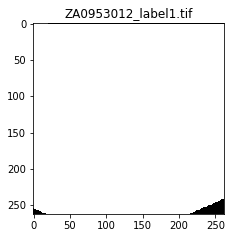

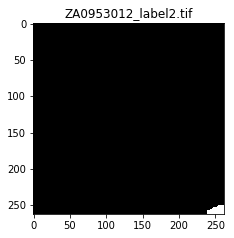

In [99]:
testdir = os.path.join(ROOT_DIR,'train/ZA0953012/masks')
labs = next(os.walk(testdir))[2]
os.chdir(testdir)
for path in labs:
    arr = skio.imread(path)
    all_labels = measure.label(arr)
    plt.figure(figsize=(9, 3.5))
    plt.subplot(131)
    plt.imshow(arr, cmap='gray')
    plt.title(path)
    plt.tight_layout()
    plt.show()

/home/rave/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


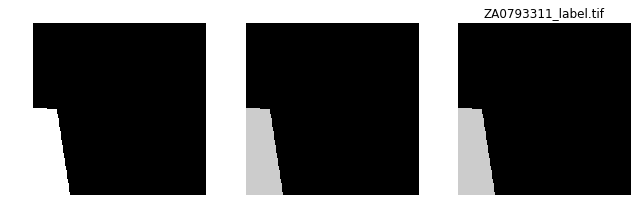

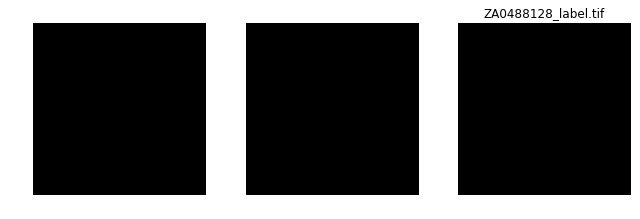

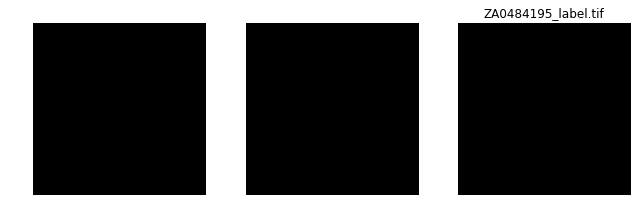

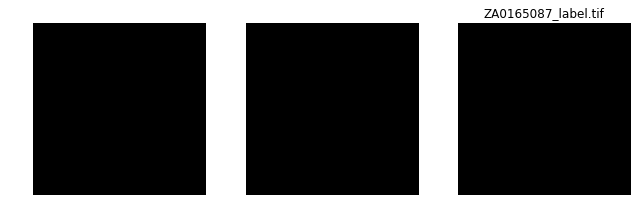

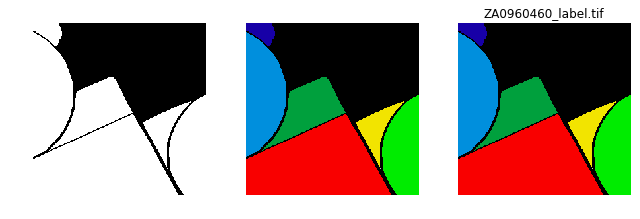

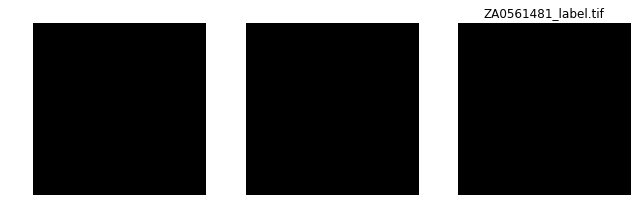

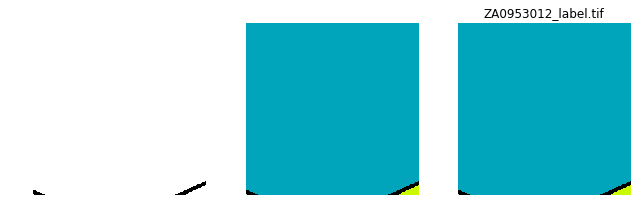

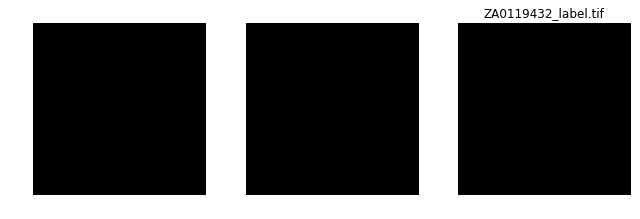

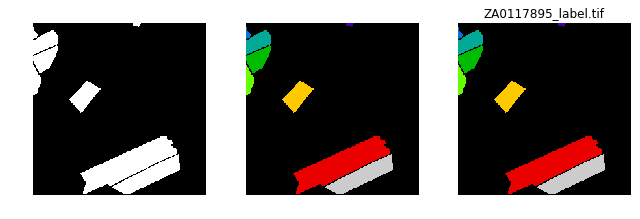

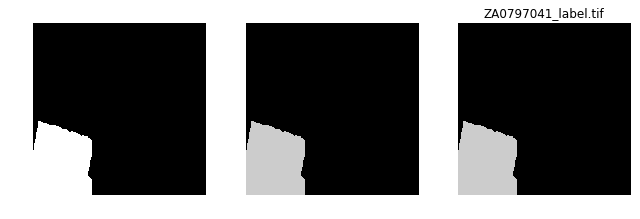

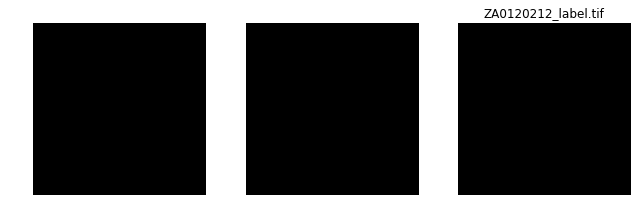

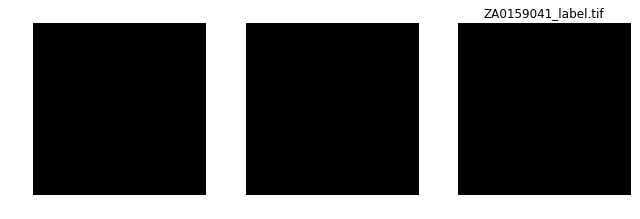

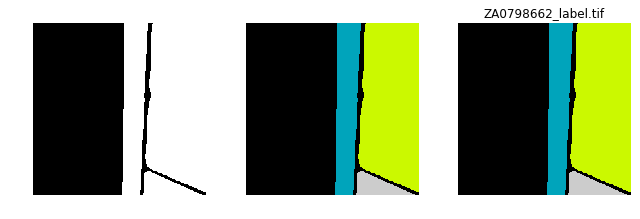

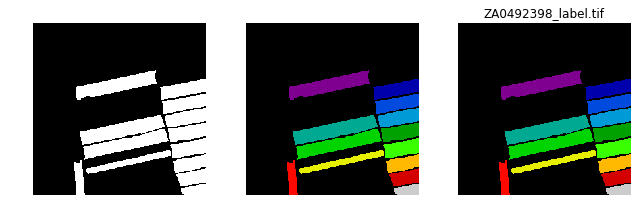

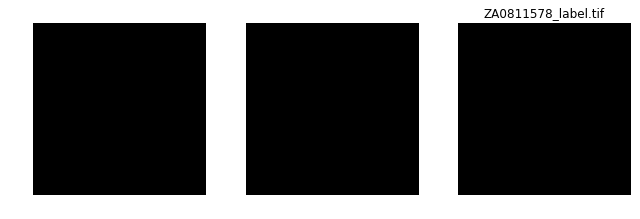

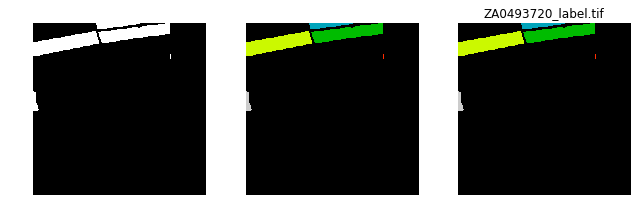

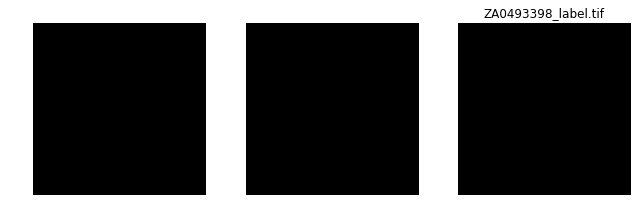

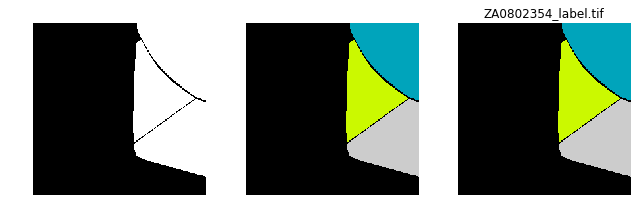

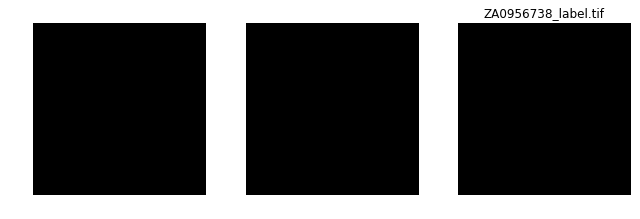

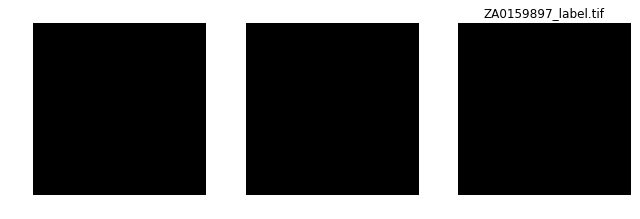

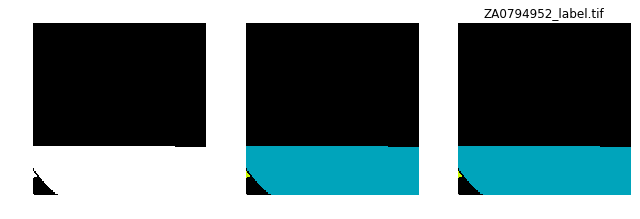

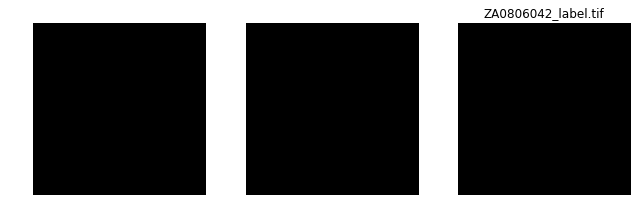

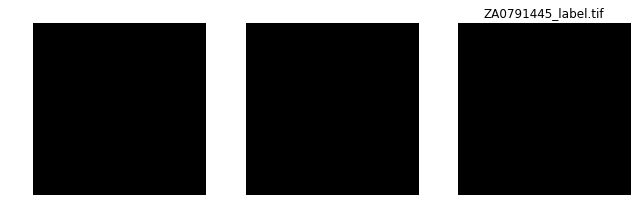

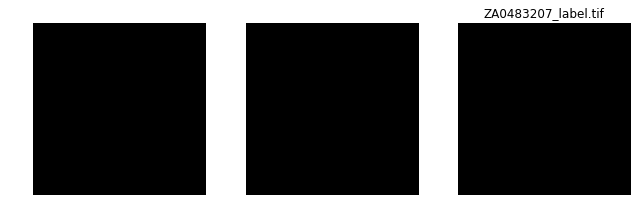

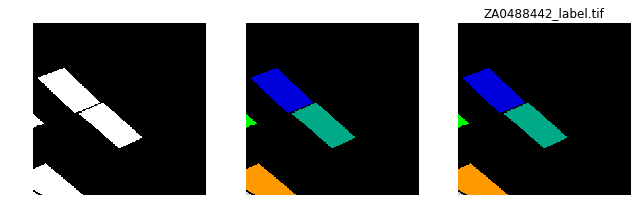

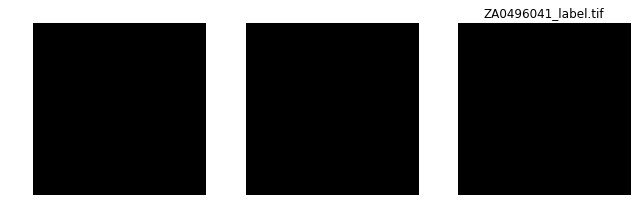

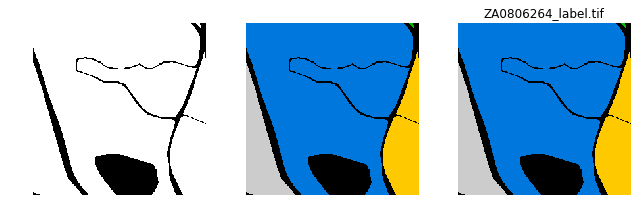

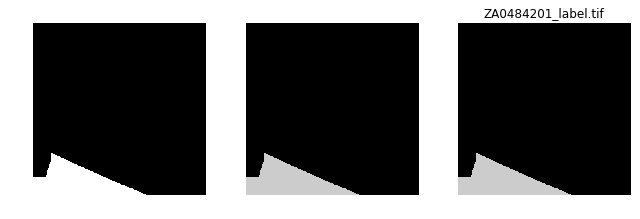

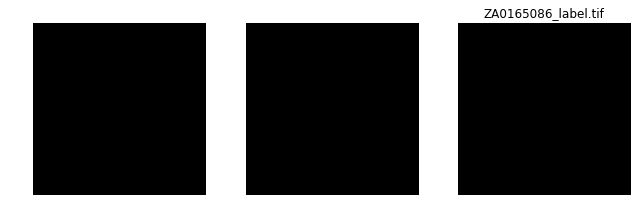

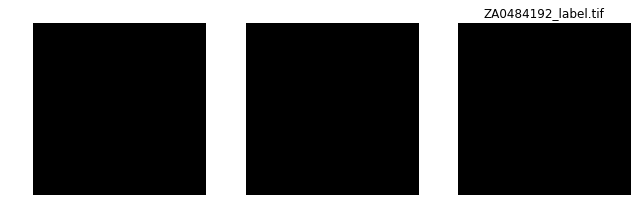

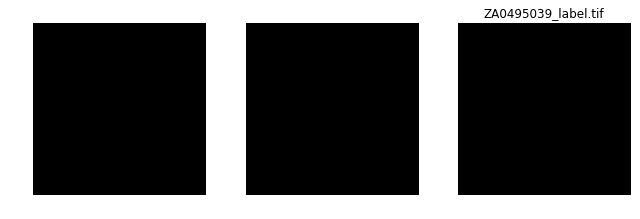

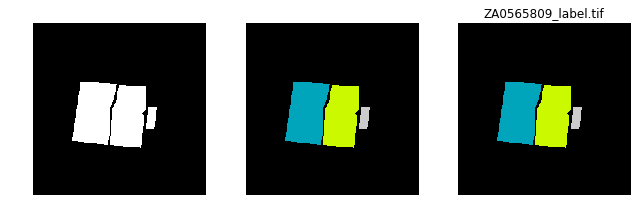

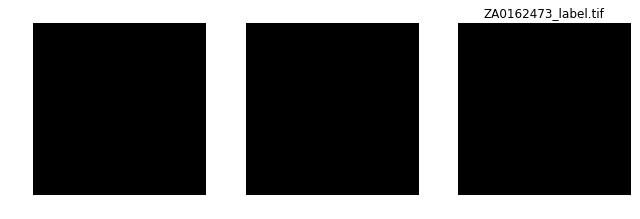

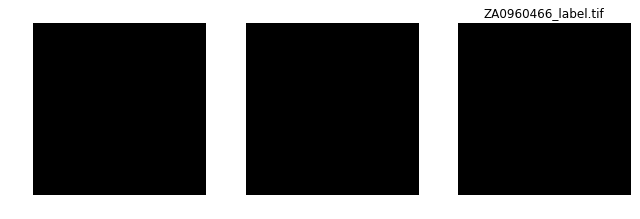

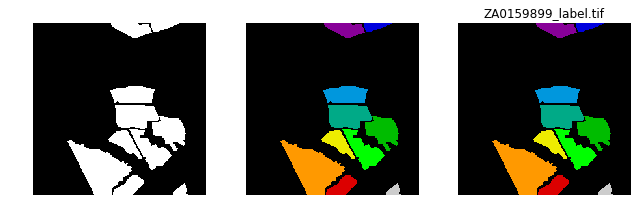

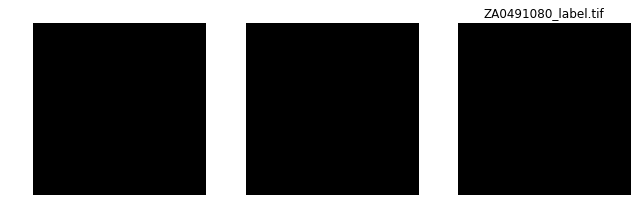

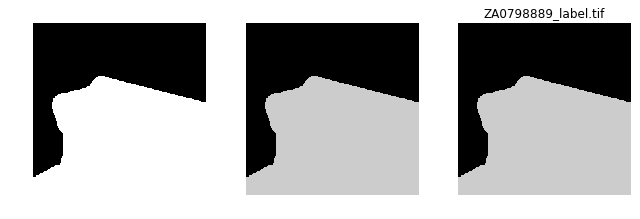

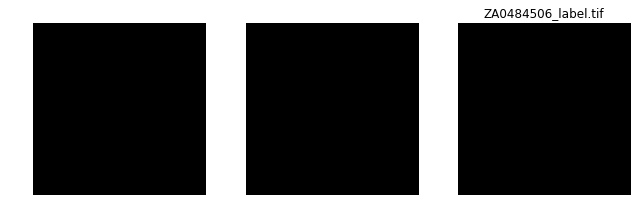

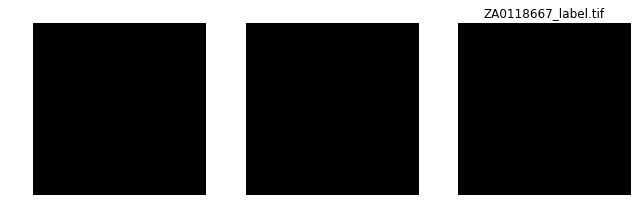

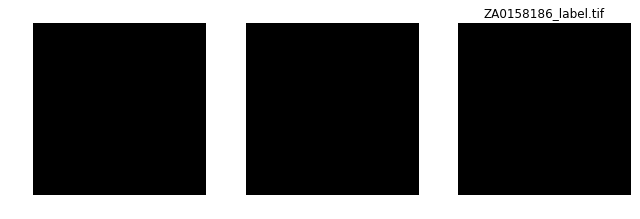

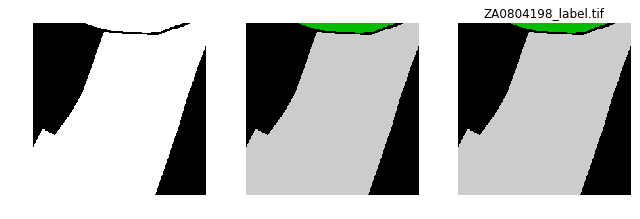

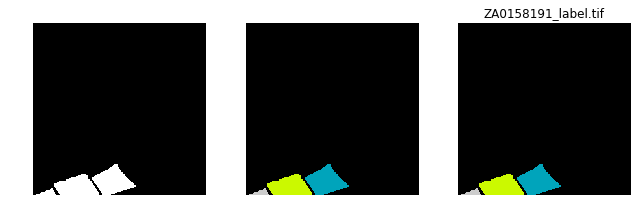

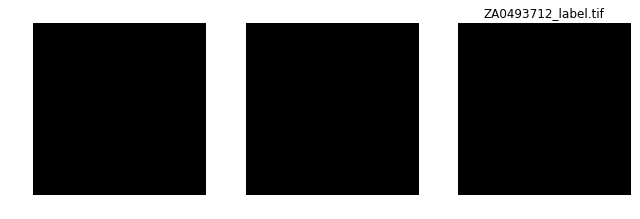

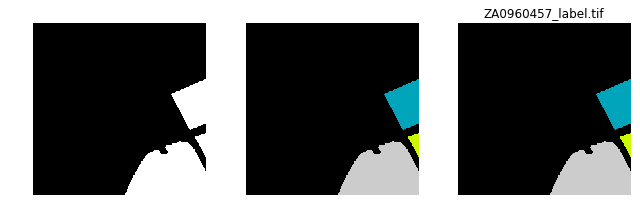

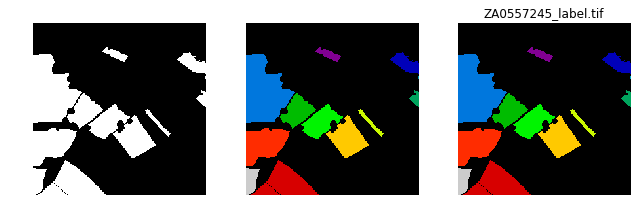

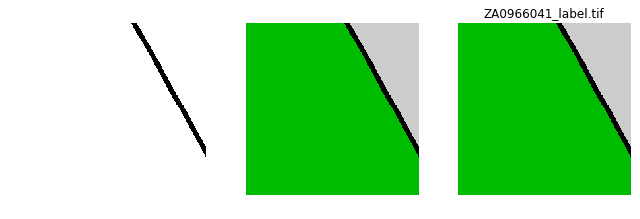

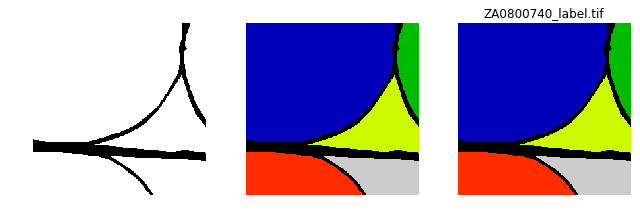

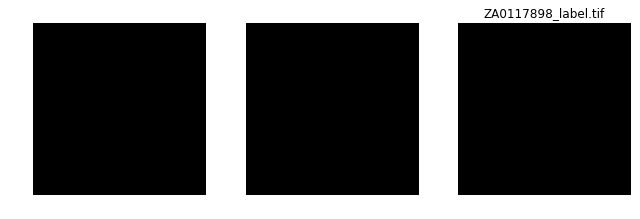

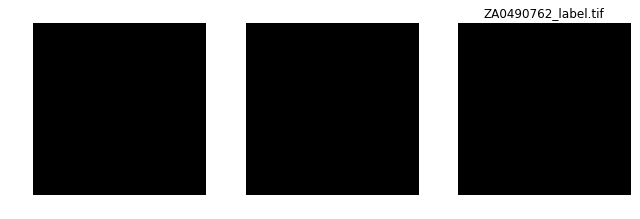

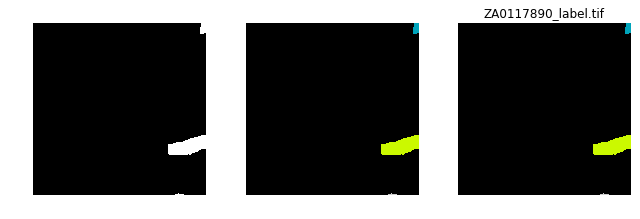

In [26]:
os.chdir(LABELS_DIR)
for path in label_list[0:50]:
    arr = skio.imread(path)
    arr[arr == -1.7e+308]=0
    all_labels = measure.label(arr)
    blob_labels = measure.label(arr, background=0)
    plt.figure(figsize=(9, 3.5))
    plt.subplot(131)
    plt.imshow(arr, cmap='gray')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(all_labels, cmap='spectral')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(blob_labels, cmap='spectral')
    plt.axis('off')
    plt.title(path)
    plt.tight_layout()
    plt.show()

Does keeping no data from partial grid coverage lead to too much edge effects?

In [24]:
arr[arr == -1.7e+308]=0

In [25]:
np.unique(arr)

array([0., 1.])

### Moving training images and masks to nucleus kaggle competiton folder structure that nucleus mrcnn example expects

In [6]:
import random
import shutil
random.seed(42)

def train_test_split(imagerydir, traindir, testdir, kprop):
    """Splits tifs into train and test dir."""
    
    image_list = next(os.walk(imagerydir))[2]
    k = round(kprop*len(image_list))
    test_list = random.sample(image_list,k)
    for test in test_list:
        shutil.copyfile(os.path.join(imagerydir,test),os.path.join(testdir,test))
    train_list = list(set(next(os.walk(imagerydir))[2]) - set(test_list))
    for train in train_list:
        shutil.copyfile(os.path.join(imagerydir,train),os.path.join(traindir,train))
    print(len(train_list))
    print(len(test_list))
    
train_test_split(EIGHTCHANNEL_DIR,TRAIN_DIR, TEST_DIR, .1)

groundtruth_list = next(os.walk(GROUNDTRUTH_DIR))[2]
for file in groundtruth_list:
    shutil.copyfile(os.path.join(GROUNDTRUTH_DIR,file),os.path.join(VALIDATION_DIR,file))

7
1
